<a href="https://colab.research.google.com/github/bonareri/Bitcoin-Prediction-Analysis/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install praw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 3.5 MB/s eta 0:00:00


In [22]:
! pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.6 MB/s eta 0:00:00


In [20]:
# Essential Libraries
import re
import spacy
import praw
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

# NLP & Sentiment Analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Visualization
from wordcloud import WordCloud

# NLTK Downloads (only necessary ones)
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [21]:
# Initialize Reddit API
reddit = praw.Reddit(
    client_id="ZRSYUiHRJOl_3XR_6ifWwQ",
    client_secret="CEeasW1hnMozmDPGh8YXBUZMN6jV9Q",
    user_agent="BitcoinScraper"
)

# List of subreddits
subreddits = ["Bitcoin", "CryptoCurrency", "CryptoMarkets"]

# Store data
posts = []

for sub in subreddits:
    subreddit = reddit.subreddit(sub)
    for post in subreddit.hot(limit=1000):  # Increase limit for more data
        posts.append([sub, post.title, post.url, post.score, post.num_comments, post.created_utc])

# Convert to DataFrame
df = pd.DataFrame(posts, columns=["Subreddit", "Title", "URL", "Upvotes", "Comments", "Timestamp"])

# Save to CSV
df.to_csv("reddit_crypto_data.csv", index=False)
print("✅ Data saved to reddit_crypto_data.csv")

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

✅ Data saved to reddit_crypto_data.csv


In [4]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 33.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [27]:
#load data
df = pd.read_csv("/content/reddit_crypto_data.csv")
df.head()

,Subreddit,Title,URL,Upvotes,Comments,Timestamp
0,Bitcoin,"Mentor Monday, February 10, 2025: Ask all your...",https://www.reddit.com/r/Bitcoin/comments/1im0...,16,18,1.739171e+09
1,Bitcoin,"Daily Discussion, February 10, 2025",https://www.reddit.com/r/Bitcoin/comments/1ilz...,22,91,1.739167e+09
2,Bitcoin,Willing to meet halfway 😜,https://i.redd.it/sri21fzyxcie1.jpeg,756,21,1.739213e+09
3,Bitcoin,Proud of North Carolina for joining in!,https://i.redd.it/96jsszyn0die1.jpeg,431,45,1.739214e+09
4,Bitcoin,We are at a point where we don’t know what wil...,https://i.redd.it/np1if0j8vbie1.jpeg,677,65,1.739200e+09


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1497 entries, 0 to 1496
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Subreddit  1497 non-null   object 
 1   Title      1497 non-null   object 
 2   URL        1497 non-null   object 
 3   Upvotes    1497 non-null   int64  
 4   Comments   1497 non-null   int64  
 5   Timestamp  1497 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 70.3+ KB


In [29]:
df = df.drop(columns=["URL", "Timestamp"])
print(df.head())  # Confirm removal

  Subreddit                                              Title  Upvotes  \
0   Bitcoin  Mentor Monday, February 10, 2025: Ask all your...       16   
1   Bitcoin                Daily Discussion, February 10, 2025       22   
2   Bitcoin                          Willing to meet halfway 😜      756   
3   Bitcoin            Proud of North Carolina for joining in!      431   
4   Bitcoin  We are at a point where we don’t know what wil...      677   

   Comments  
0        18  
1        91  
2        21  
3        45  
4        65  


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1497 entries, 0 to 1496
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Subreddit  1497 non-null   object
 1   Title      1497 non-null   object
 2   Upvotes    1497 non-null   int64 
 3   Comments   1497 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 46.9+ KB


In [25]:
print(df["Subreddit"].unique())

['Bitcoin' 'CryptoCurrency' 'CryptoMarkets']


## Data Preprocessing

### 🧹 Tweet Cleaning & Preprocessing

#### ✅ Steps Taken:
1. **Removed Mentions** (`@username`)  
2. **Removed URLs** (e.g., `http://example.com`)  
3. **Removed Special Characters** (kept only letters and spaces)  
4. **Converted to Lowercase** (standardized text format)  
5. **Removed Stopwords** (common words like *the, is, and, for, in, by*)  
6. **Lemmatized Words** (converted words to their base form, e.g., *running → run*)

In [31]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

def clean_text(text):
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters
    return text.lower().strip()  # Convert to lowercase

# Apply cleaning function
df["cleaned_text"] = df["Title"].astype(str).apply(clean_text)  # Assuming "Title" holds the text

df.head()

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


,Subreddit,Title,Upvotes,Comments,cleaned_text
0,Bitcoin,"Mentor Monday, February 10, 2025: Ask all your...",16,18,mentor monday february ask all your bitcoin ...
1,Bitcoin,"Daily Discussion, February 10, 2025",22,91,daily discussion february
2,Bitcoin,Willing to meet halfway 😜,756,21,willing to meet halfway
3,Bitcoin,Proud of North Carolina for joining in!,431,45,proud of north carolina for joining in
4,Bitcoin,We are at a point where we don’t know what wil...,677,65,we are at a point where we dont know what will...


## Sentiment Analysis

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.

VADER takes into account

negations and contractions (not good, wasn’t good) Punctuation (good!!!), CAPS, emotes :), emojis Intensificators (very, kind of), acronyms ‘lol’ Scores between -1.0 (negative) and 1.0 (positive)

In [32]:
# Download VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')

# Initialize Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [33]:
# Function to get sentiment scores
def get_sentiment(text):
    sentiment = sia.polarity_scores(text)
    return sentiment["compound"]  # Compound score represents overall sentiment

# Apply sentiment analysis to the "Title" column
df["Sentiment_Score"] = df["Title"].astype(str).apply(get_sentiment)

# Classify Sentiment (Positive, Neutral, Negative)
df["Sentiment"] = df["Sentiment_Score"].apply(lambda x: "Positive" if x > 0.05 else "Negative" if x < -0.05 else "Neutral")

# View results
df[["Title", "Sentiment_Score", "Sentiment"]].head()

,Title,Sentiment_Score,Sentiment
0,"Mentor Monday, February 10, 2025: Ask all your...",0.0000,Neutral
1,"Daily Discussion, February 10, 2025",0.0000,Neutral
2,Willing to meet halfway 😜,0.0000,Neutral
3,Proud of North Carolina for joining in!,0.5255,Positive
4,We are at a point where we don’t know what wil...,0.0000,Neutral


### Visualizing Sentiment Distribution

<ipython-input-35-cc506875be0d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Sentiment"], palette="coolwarm")


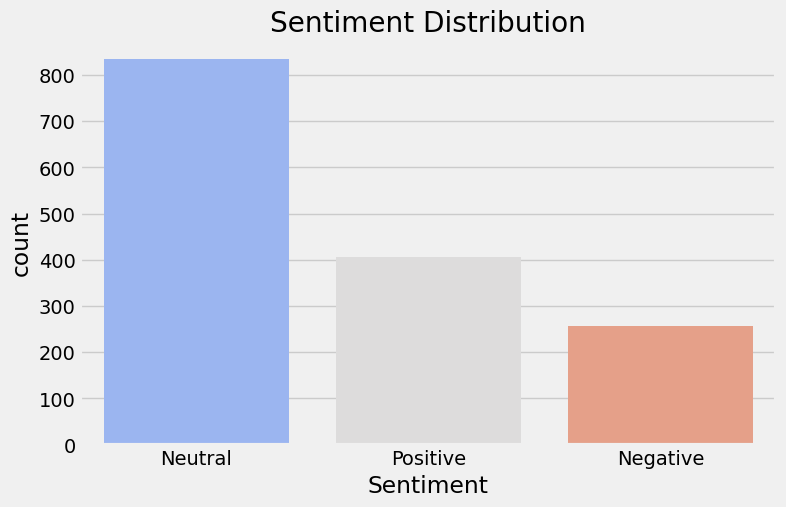

In [35]:
plt.figure(figsize=(8,5))
sns.countplot(x=df["Sentiment"], palette="coolwarm")
plt.title("Sentiment Distribution")
plt.show()

In [36]:
sentiment_by_subreddit = df.groupby("Subreddit")["Sentiment"].value_counts().unstack()
print(sentiment_by_subreddit)

Sentiment       Negative  Neutral  Positive
Subreddit                                  
Bitcoin              107      434       214
CryptoCurrency        49      103        63
CryptoMarkets        100      298       129


### Generate Word Clouds

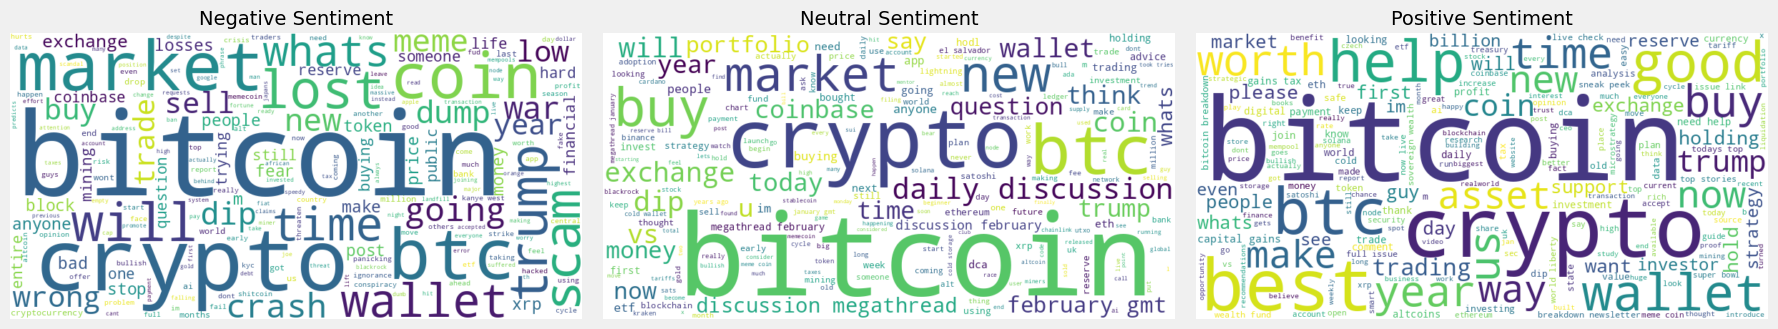

In [38]:
# Create a dictionary to store text for each sentiment
sentiment_texts = {
    "Negative": ' '.join(df[df['Sentiment'] == 'Negative']['cleaned_text']),
    "Neutral": ' '.join(df[df['Sentiment'] == 'Neutral']['cleaned_text']),
    "Positive": ' '.join(df[df['Sentiment'] == 'Positive']['cleaned_text'])
}

# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Generate and plot word clouds
for ax, (sentiment, text) in zip(axes, sentiment_texts.items()):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"{sentiment} Sentiment", fontsize=14)
    ax.axis('off')

plt.tight_layout()
plt.show()

### Compare VADER sentiment scores with the actual text content.

In [40]:
# Function to get VADER sentiment score
def get_vader_sentiment(text):
    score = sia.polarity_scores(text)["compound"]
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

# Apply VADER sentiment analysis
df["VADER_Sentiment"] = df["cleaned_text"].astype(str).apply(get_vader_sentiment)

# Compare actual sentiment vs. VADER's predicted sentiment
comparison_df = df[["cleaned_text", "Sentiment", "VADER_Sentiment"]].sample(10)  # Select random 10 samples for comparison

# Display comparison
print(comparison_df)

                                           cleaned_text Sentiment  \
287   btc vs gold aka how running the peter schiff p...   Neutral   
1310  help whats some good trading pairs for dayswin...  Positive   
1055                                   i got shaken out  Negative   
1260  trump tariffs still coming saturday white hous...   Neutral   
523                                   btc in a nutshell   Neutral   
852   how close to  is the chance of recovering the ...  Positive   
740                                  do i need multisig   Neutral   
1189                        repeatedly bought the highs   Neutral   
1060                           the german election soon   Neutral   
59    bitcoin wasnt the first attempt at a digital c...   Neutral   

     VADER_Sentiment  
287          Neutral  
1310        Positive  
1055        Negative  
1260         Neutral  
523          Neutral  
852         Positive  
740          Neutral  
1189         Neutral  
1060         Neutral  
59        

### Tokenize & Count Word Frequencies

In [42]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Tokenization function
def tokenize_text(text):
    tokens = word_tokenize(text)  # Tokenize text
    tokens = [word.lower() for word in tokens if word.isalpha()]  # Keep only words (remove punctuation & numbers)
    return tokens

# Apply tokenization
df["tokens"] = df["cleaned_text"].astype(str).apply(tokenize_text)

# Flatten the list of all words
all_words = [word for tokens in df["tokens"] for word in tokens]

# Remove stopwords
stop_words = set(stopwords.words("english"))
filtered_words = [word for word in all_words if word not in stop_words]

# Count word frequencies
word_freq = Counter(filtered_words)

# Get the most common words
most_common_words = word_freq.most_common(20)  # Top 20 words

# Convert to DataFrame for visualization
word_freq_df = pd.DataFrame(most_common_words, columns=["Word", "Frequency"])

# Plot word frequencies
plt.figure(figsize=(12, 6))
sns.barplot(x="Frequency", y="Word", data=word_freq_df, palette="viridis")
plt.title("Top 20 Most Frequent Words")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


### Feature Extraction:
**Text Vectorization**

Text data needs to be transformed into numerical format since machine learning models cannot directly work with text.

I will choose TF-IDF (Term Frequency-Inverse Document Frequency) because it reflects how important a word is within a document and across the entire dataset. This is particularly useful for capturing the essence of a text review without giving too much importance to common words (like "the", "is", etc.).

TF-IDF Explanation:

TF (Term Frequency): Measures how frequently a word appears in a document.
IDF (Inverse Document Frequency): Measures how common or rare a word is across all documents. Rare words are given higher weightage.

In [ ]:
# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Limit to top 1000 words
X_tfidf = tfidf_vectorizer.fit_transform(df["cleaned_text"])

# Convert to DataFrame for better readability
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df.head()

,adoption,aka,alert,altcoin,analyst,announcement,anticipate,approval,asset,bankmanfrieds,...,touch,tpu,trading,trump,undervalue,video,wave,week,year,youtube
0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.313666,0.0,0.313666,...,0.00000,0.000000,0.00000,0.313666,0.0,0.000000,0.0,0.00000,0.000000,0.000000
1,0.200897,0.000000,0.0,0.170781,0.200897,0.200897,0.200897,0.000000,0.0,0.000000,...,0.00000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.000000
2,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.25918,0.000000,0.25918,0.000000,0.0,0.000000,0.0,0.25918,0.000000,0.000000
3,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.00000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.000000
4,0.000000,0.189366,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.00000,0.189366,0.00000,0.000000,0.0,0.189366,0.0,0.00000,0.378732,0.189366


## Model Training

### Splitting Data for Training & Testing

In [ ]:
# Define features (X) and target (y)
X = X_tfidf  # Using TF-IDF features
y = df["VADER_Sentiment"]  # Target labels

# Split into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

Training samples: 8, Testing samples: 2


### Logistic Regression

In [ ]:
# Initialize model
model = LogisticRegression(max_iter=500)

# Train the model
model.fit(X_train, y_train)

LogisticRegression(max_iter=500)

### Evaluate Model Performance

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

# Print evaluation metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.50
              precision    recall  f1-score   support

     Neutral       0.00      0.00      0.00         1
    Positive       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2

